In [140]:
#Import libraries

import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import h5py


In [141]:
def import_h5(directory, experiment_title):
    """
    Import H5 files, extract image data and metadata, and perform denoising.

    Parameters
    ----------
    directory : str
        Path to the directory containing the H5 files.
    experiment_title : str
        Title of the experiment, used to identify relevant files.

    Returns
    -------
    dict
        A dictionary containing image arrays, exposure times, darkcount images, and denoised images.
    """
    laser_wavelengths = {'1': '670', '2': '760', '3': '808'}
    emission_filters = {'12': 'BP1150', '13': 'BP1200', '14': 'BP1250', '15': 'BP1300', '16': 'BP1350', '17': 'BP1575'}

    # Input validation
    if not os.path.isdir(directory):
        raise ValueError(f"The directory {directory} does not exist.")
    if not isinstance(experiment_title, str):
        raise ValueError("experiment_title must be a string.")

    # Get the list of darkcount files
    darkcount_files = sorted([f for f in os.listdir(directory) if f.startswith('darkcounts')],
                             key=lambda x: float(x[10:-3]))

    # Initialize a dictionary to store the image file lists
    image_files = {}

    # Get the list of image files for each parameter combination
    for laser_key, laser_value in laser_wavelengths.items():
        for filter_key, filter_value in emission_filters.items():
            key = f"{experiment_title}_{laser_value}_{filter_value}"
            image_files[key] = sorted([f for f in os.listdir(directory) if f.startswith(f"{experiment_title}_{laser_key}_{filter_key}")],
                                      key=lambda x: float(x.split('_')[-1][:-3]))

    # Read the darkcount files and store the data
    darkcount_data = []
    exposure_times = []
    for file in darkcount_files:
        file_path = os.path.join(directory, file)
        with h5py.File(file_path, 'r') as h5f:
            darkcount = h5f['Cube']['Images'][()]
            exposure_time = h5f['Cube']['TimeExposure'][()].item()
            darkcount_data.append(darkcount)
            exposure_times.append(exposure_time)

    # Concatenate the darkcount data into an array with dimensions (num_exposure_times, height, width)
    darkcount_array = np.squeeze(np.array(darkcount_data))

    # Convert exposure_times to a NumPy array
    exposure_times = np.array(exposure_times)

    # Read the image files and store the data for each parameter combination
    image_arrays = {}
    for key, files in image_files.items():
        image_data = []
        for file in files:
            file_path = os.path.join(directory, file)
            with h5py.File(file_path, 'r') as h5f:
                image = h5f['Cube']['Images'][()]
                image_data.append(image)
        image_arrays[key] = np.squeeze(np.array(image_data))

    # Calculate the mean and standard deviation of pixel intensities for each exposure time in the darkcount cube
    darkcount_mean = np.mean(darkcount_array, axis=(1, 2))
    darkcount_std = np.std(darkcount_array, axis=(1, 2))
    print("Average darkcount value:", darkcount_mean)
    print("Darkcount standard deviation:", darkcount_std)

    # Define the threshold multiplier (e.g., 2 for mean + 2*std)
    threshold_multiplier = 0

    # Create a dictionary to store the denoised image arrays
    image_denoised_arrays = {}

    # Zero out pixels below the threshold in each image cube
    for key in image_arrays.keys():
        threshold = darkcount_mean + threshold_multiplier * darkcount_std
        denoised_array = np.where(image_arrays[key] > threshold[:, np.newaxis, np.newaxis],
                                  image_arrays[key] - threshold[:, np.newaxis, np.newaxis],
                                  0)
        # Convert to 16-bit integers
        image_denoised_arrays[key] = denoised_array.astype(np.uint16)

    print("Threshold:", threshold)
    print("Denoised arrays shape:", image_denoised_arrays[key].shape)

    # Print the shapes of the arrays
    print("Darkcount array shape:", darkcount_array.shape)
    print("Exposure times array shape:", exposure_times.shape)
    print("Exposure times:", exposure_times)
    for key in image_arrays.keys():
        print(f"Image array shape for {key}:", image_arrays[key].shape)

    return {
        "images": image_arrays,
        "exposure_times": exposure_times,
        "darkcount_images": darkcount_array,
        "denoised_images": image_denoised_arrays
    }

In [142]:
def plot_image_array(image_set, exposure_times):
    """
    Plot a tight arrangement of the full series of exposure times for each imaging condition on the same intensity scale.

    Parameters
    ----------
    image_set : dict
        A dictionary containing image arrays for different conditions.
    exposure_times : numpy.ndarray
        An array of exposure times corresponding to the images.
    """
    # Input validation
    if not isinstance(image_set, dict):
        raise ValueError("image_set must be a dictionary.")
    if not isinstance(exposure_times, np.ndarray):
        raise ValueError("exposure_times must be a numpy array.")

    # Extract the minimum and maximum intensity values for each image array
    min_max_dict = {key: (np.min(array), np.max(array)) for key, array in image_set.items()}

    # Print the minimum and maximum intensity values for each image array
    for key, (min_val, max_val) in min_max_dict.items():
        print(f"Intensity range for {key}: Min = {min_val}, Max = {max_val}")

    # Plot the image arrays using the same intensity scale
    for key, array in image_set.items():
        fig, axes = plt.subplots(1, array.shape[0], figsize=(15, 2))
        fig.suptitle(key)
    
        min_val, max_val = min_max_dict[key]
    
        for i in range(array.shape[0]):
            ax = axes[i]
            ax.imshow(array[i, :, :], cmap='gray', vmin=min_val, vmax=max_val)
            ax.set_title(f'{exposure_times[i]} s')
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

In [143]:
def linearWeight(pixel_value, z_min, z_max):
    """
    Linear weighting function based on pixel intensity that reduces the
    weight of pixel values that are near saturation.

    Parameters
    ----------
    pixel_value : int or numpy.ndarray
        A pixel intensity value or array of values
    z_min : int
        Minimum possible pixel value
    z_max : int
        Maximum possible pixel value

    Returns
    -------
    weight : float or numpy.ndarray
        The weight(s) corresponding to the input pixel intensity(ies)
    """
    pixel_value = np.asarray(pixel_value)
    mid = (z_min + z_max) / 2
    weight = np.where(pixel_value <= mid, 
                      pixel_value - z_min, 
                      z_max - pixel_value)
    return weight.astype(np.float32)

In [144]:
def plot_weighting_function(weighting_function, z_min, z_max):
    """
    Plot the weighting function against pixel intensity.

    Parameters:
    weighting_function : callable
        The weighting function to be plotted
    z_min : int
        Minimum pixel value
    z_max : int
        Maximum pixel value
    """
    pixel_values = np.arange(z_min, z_max + 1)
    weights = [weighting_function(z, z_min, z_max) for z in pixel_values]

    plt.figure(figsize=(10, 6))
    plt.plot(pixel_values, weights)
    plt.title("Weighting Function")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Weight")
    plt.xlim(z_min, z_max)
    plt.ylim(0, max(weights) * 1.1)  # Set y-axis limit to slightly above max weight
    plt.grid(True)
    plt.show()

In [145]:
def estimate_radiance(images, exposure_times):
    """
    Estimate the relative radiance for each pixel.
    
    Parameters:
    images : numpy.ndarray
        Stack of images (shape: num_images x height x width)
    exposure_times : numpy.ndarray
        Array of exposure times for each image
    
    Returns:
    numpy.ndarray
        Estimated radiance map
    """
    num_images, height, width = images.shape
    radiance = np.zeros((height, width))
    weight_sum = np.zeros((height, width))
    
    for i in range(num_images):
        # Simple weighting function: give more weight to mid-range pixel values
        weights = 1 - 2 * np.abs(images[i].astype(float) / np.max(images[i]) - 0.5)
        radiance += weights * images[i].astype(float) / exposure_times[i]
        weight_sum += weights
    
    return radiance / np.maximum(weight_sum, 1e-6)  # Avoid division by zero

In [146]:
def sampleIntensities(images, exposure_times, num_samples=5000):
    """
    Sample pixel intensities from the exposure stack, ensuring full intensity range coverage.

    Parameters
    ----------
    images : numpy.ndarray
        A 3D array containing a stack of single-channel images
        Shape: (num_images, height, width)
    exposure_times : numpy.ndarray
        Array of exposure times for each image
    num_samples : int, optional
        Target number of pixel locations to sample

    Returns
    -------
    intensity_samples : numpy.array
        An array containing sampled intensity values from each
        exposure layer (shape = num_samples x num_images)
    log_exposures : numpy.array
        An array containing log exposure values for each sample
    z_min : int
        Minimum intensity value in the images
    z_max : int
        Maximum intensity value in the images
    """
    if not isinstance(images, np.ndarray) or images.ndim != 3:
        raise ValueError("images must be a 3D numpy array")

    num_images, height, width = images.shape
    z_min = int(np.min(images))
    z_max = int(np.max(images))
    print(f"z_max: {z_max}; z_min: {z_min}")

    # Estimate radiance
    radiance = estimate_radiance(images, exposure_times)

    # Find the image with the widest intensity distribution
    intensity_ranges = [np.ptp(img) for img in images]
    widest_range_index = np.argmax(intensity_ranges)
    widest_range_image = images[widest_range_index]

    # Create bins across the full intensity range
    num_bins = min(num_samples, z_max - z_min + 1)
    bins = np.linspace(z_min, z_max, num_bins + 1, dtype=int)

    # Sample pixels from each bin
    sampled_pixels = []
    for i in range(len(bins) - 1):
        bin_mask = (widest_range_image >= bins[i]) & (widest_range_image < bins[i+1])
        pixels_in_bin = np.where(bin_mask)
        if len(pixels_in_bin[0]) > 0:
            # Randomly select one pixel from this bin
            idx = np.random.randint(len(pixels_in_bin[0]))
            sampled_pixels.append((pixels_in_bin[0][idx], pixels_in_bin[1][idx]))

    # Initialize the intensity values and log exposure arrays
    intensity_samples = np.zeros((len(sampled_pixels), num_images), dtype=np.uint16)
    log_exposures = np.zeros((len(sampled_pixels), num_images))

    # Sample the selected pixels across all exposures
    for i, (row, col) in enumerate(sampled_pixels):
        for j in range(num_images):
            intensity_samples[i, j] = images[j, row, col]
            log_exposures[i, j] = np.log(radiance[row, col] * exposure_times[j])

    # Remove any rows where all values are 0 or saturated
    valid_samples = np.all((intensity_samples > 0) & (intensity_samples < z_max), axis=1)
    intensity_samples = intensity_samples[valid_samples]
    log_exposures = log_exposures[valid_samples]

    print(f"Number of valid samples: {intensity_samples.shape[0]}")

    return intensity_samples, log_exposures, z_min, z_max

In [147]:
def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function, z_min, z_max):
    """
    Find the camera response curve for a single color channel

    Parameters
    ----------
    intensity_samples : numpy.ndarray
        Sampled intensity values (shape = num_samples x num_images)
    log_exposures : numpy.ndarray
        Log exposure values (shape = num_samples x num_images)
    smoothing_lambda : float
        Constant for scale correction between data and smoothing terms
    weighting_function : callable
        Function that computes a weight from a pixel intensity
    z_min : int
        Minimum intensity value
    z_max : int
        Maximum intensity value

    Returns
    -------
    numpy.ndarray
        Vector g(z) where g[i] is the log exposure of intensity value z_min + i
    """
    if not isinstance(intensity_samples, np.ndarray) or intensity_samples.ndim != 2:
        raise ValueError("intensity_samples must be a 2D numpy array")
    if not isinstance(log_exposures, np.ndarray) or log_exposures.ndim != 2:
        raise ValueError("log_exposures must be a 2D numpy array")
    if intensity_samples.shape != log_exposures.shape:
        raise ValueError("intensity_samples and log_exposures must have the same shape")

    num_samples, num_images = intensity_samples.shape
    intensity_range = z_max - z_min + 1

    # Calculate the total number of constraints
    data_constraints = num_samples * num_images
    smoothness_constraints = intensity_range - 2
    monotonicity_constraints = intensity_range - 1
    total_constraints = data_constraints + smoothness_constraints + monotonicity_constraints

    mat_A = np.zeros((total_constraints, intensity_range), dtype=np.float64)
    mat_b = np.zeros((total_constraints, 1), dtype=np.float64)

    k = 0
    # Data-fitting constraints
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            w_ij = weighting_function(z_ij, z_min, z_max)
            mat_A[k, z_ij - z_min] = w_ij
            mat_b[k, 0] = w_ij * log_exposures[i, j]
            k += 1

    # Smoothness constraints
    for z_k in range(z_min + 1, z_max):
        w_k = weighting_function(z_k, z_min, z_max)
        mat_A[k, z_k - z_min - 1:z_k - z_min + 2] = w_k * smoothing_lambda * np.array([-1, 2, -1])
        k += 1

    # Monotonicity constraints
    for z_k in range(z_min, z_max - 1):
        if k < total_constraints:
            mat_A[k, z_k - z_min] = -1
            mat_A[k, z_k - z_min + 1] = 1
            mat_b[k, 0] = 0.001  # Small positive value to ensure strict monotonicity
            k += 1
        else:
            break

    # Solve the system
    x = np.linalg.lstsq(mat_A, mat_b, rcond=None)[0]

    return x.flatten()

In [148]:
def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function, z_min, z_max):
    """
    Calculate a radiance map for each pixel from the response curve.

    Parameters
    ----------
    images : numpy.ndarray
        3D array containing single-channel images (num_images, height, width)
    log_exposure_times : numpy.ndarray
        Array containing the log exposure times for each image
    response_curve : numpy.ndarray
        Least-squares fitted log exposure of each pixel value z
    weighting_function : callable
        Function that computes the weights
    z_min : int
        Minimum intensity value
    z_max : int
        Maximum intensity value

    Returns
    -------
    numpy.ndarray
        The image radiance map (in log space)
    """
    if not isinstance(images, np.ndarray) or images.ndim != 3:
        raise ValueError("images must be a 3D numpy array")
    if not isinstance(log_exposure_times, np.ndarray) or log_exposure_times.ndim != 1:
        raise ValueError("log_exposure_times must be a 1D numpy array")
    if images.shape[0] != log_exposure_times.shape[0]:
        raise ValueError("Number of images and exposure times must match")

    num_images, height, width = images.shape
    img_rad_map = np.zeros((height, width), dtype=np.float32)
    sum_weights = np.zeros((height, width), dtype=np.float32)

    for i in range(num_images):
        w = weighting_function(images[i], z_min, z_max)
        img_rad_map += w * (response_curve[np.clip(images[i] - z_min, 0, len(response_curve) - 1)] - log_exposure_times[i])
        sum_weights += w

    # Avoid division by zero
    sum_weights[sum_weights == 0] = 1e-6
    img_rad_map /= sum_weights

    return img_rad_map

In [149]:
def globalToneMapping(image, gamma):
    """
    Global tone mapping using gamma correction

    Parameters
    ----------
    image : numpy.ndarray
        Image needed to be corrected
    gamma : float
        The number for gamma correction. Higher value for brighter result; lower for darker

    Returns
    -------
    numpy.ndarray
        The resulting image after gamma correction
    """
    if not isinstance(image, np.ndarray):
        raise ValueError("image must be a numpy array")
    if not isinstance(gamma, (int, float)) or gamma <= 0:
        raise ValueError("gamma must be a positive number")

    # Ensure all values are non-negative
    image = np.maximum(image, 0)
    
    # Avoid division by zero
    max_val = np.max(image)
    if max_val == 0:
        return np.zeros_like(image)
    
    return cv2.pow(image / max_val, 1.0 / gamma)

In [150]:
def intensityAdjustment(image, template):
    """
    Tune image intensity based on template

    Parameters
    ----------
    image : numpy.ndarray
        2D array of image to be adjusted
    template : numpy.ndarray
        2D array of template image (typically middle image from stack)

    Returns
    -------
    numpy.ndarray
        The resulting image after intensity adjustment
    """
    if not isinstance(image, np.ndarray) or image.ndim != 2:
        raise ValueError("image must be a 2D numpy array")
    if not isinstance(template, np.ndarray) or template.ndim != 2:
        raise ValueError("template must be a 2D numpy array")
    if image.shape != template.shape:
        raise ValueError("image and template must have the same shape")

    image_avg = np.average(image)
    template_avg = np.average(template)
    return image * (template_avg / image_avg)

In [151]:
def computeHDR(images, exposure_times, smoothing_lambda=1000., gamma=0.6):
    """
    Computational pipeline to produce the HDR images

    Parameters
    ----------
    images : numpy.ndarray
        A 3D array containing an exposure stack of single-channel images
        Shape: (num_images, height, width)
    log_exposure_times : numpy.ndarray
        The log exposure times for each image in the exposure stack
    smoothing_lambda : float, optional
        A constant value to correct for scale differences between
        data and smoothing terms in the constraint matrix
    gamma : float, optional
        Gamma value for tone mapping

    Returns
    -------
    tuple
        (hdr_image, response_curve)
        hdr_image : numpy.ndarray
            The resulting HDR image with intensities scaled to fit uint8 range
        response_curve : numpy.ndarray
            The computed camera response function
    """
    if not isinstance(images, np.ndarray) or images.ndim != 3:
        raise ValueError("images must be a 3D numpy array")
    if not np.issubdtype(images.dtype, np.integer):
        raise ValueError("images must be an integer type")
    if not isinstance(log_exposure_times, np.ndarray) or log_exposure_times.ndim != 1:
        raise ValueError("log_exposure_times must be a 1D numpy array")
    if images.shape[0] != log_exposure_times.shape[0]:
        raise ValueError("Number of images and exposure times must match")

    print(images.dtype)
    # Sample image intensities
    intensity_samples, log_exposures, z_min, z_max = sampleIntensities(images, exposure_times)

    # Compute Response Curve
    response_curve = computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, linearWeight, z_min, z_max)

    # Plot the response curve
    plot_response_curve(intensity_samples, log_exposures, response_curve, z_min, z_max)

    # Apply Savitzky-Golay filter to smooth the response curve
    from scipy.signal import savgol_filter
    response_curve = savgol_filter(response_curve, window_length=51, polyorder=3)

    # Build radiance map
    img_rad_map = computeRadianceMap(images, exposure_times, response_curve, linearWeight, z_min, z_max)

    print(f"1. Radiance map (log space) min: {np.min(img_rad_map)}, max: {np.max(img_rad_map)}")
    plot_radiance_map(img_rad_map)

    # Convert to linear space
    img_rad_map = np.exp(img_rad_map)
    print(f"2. Radiance map (linear space) min: {np.min(img_rad_map)}, max: {np.max(img_rad_map)}")
    plot_radiance_map(img_rad_map)

    # Normalize the radiance map to [0, 1] range
    img_rad_map = (img_rad_map - np.min(img_rad_map)) / (np.max(img_rad_map) - np.min(img_rad_map))
    print(f"3. Normalized radiance map min: {np.min(img_rad_map)}, max: {np.max(img_rad_map)}")
    plot_radiance_map(img_rad_map)

    # Global tone mapping 
    def adaptive_log_tone_mapping(x, a=0.5):
        return (np.log(1 + a * x) / np.log(1 + a)) / (np.log(1 + a * np.max(x)) / np.log(1 + a))

    image_mapped = adaptive_log_tone_mapping(img_rad_map)
    print(f"4. After tone mapping min: {np.min(image_mapped)}, max: {np.max(image_mapped)}")
    plt.figure(figsize=(10, 8))
    plt.imshow(image_mapped, cmap='gray')
    plt.title('After Tone Mapping')
    plt.colorbar()
    plt.show()

    # Adjust image intensity based on the middle image from image stack
    template = images[len(images) // 2]
    scale_factor = np.mean(template) / np.mean(image_mapped)
    image_tuned = image_mapped * scale_factor
    print(f"5. After intensity adjustment min: {np.min(image_tuned)}, max: {np.max(image_tuned)}")

    # Normalize to [0, 1] range again after adjustment
    image_tuned = (image_tuned - np.min(image_tuned)) / (np.max(image_tuned) - np.min(image_tuned))

    # Convert to 8-bit image
    hdr_image = (image_tuned * 255).astype(np.uint8)
    print(f"6. Final HDR image min: {np.min(hdr_image)}, max: {np.max(hdr_image)}")

    plt.figure(figsize=(10, 8))
    plt.imshow(hdr_image, cmap='gray')
    plt.title('Final HDR Image')
    plt.colorbar()
    plt.show()

    return hdr_image, response_curve

In [152]:
def plot_response_curve(intensity_samples, log_exposures, response_curve, z_min, z_max):
    plt.figure(figsize=(12, 8))
    
    # Plot individual data points
    for j in range(intensity_samples.shape[1]):
        plt.scatter(intensity_samples[:, j], log_exposures[:, j], alpha=0.1, s=1, c='blue')
    
    # Plot the fitted response curve
    pixel_values = np.arange(z_min, z_max + 1)
    plt.plot(pixel_values, response_curve, 'r-', linewidth=2, label='Fitted Response Curve')
    
    plt.xlabel('Pixel Value')
    plt.ylabel('Log Exposure')
    plt.title('Camera Response Function- Linear')
    plt.xscale('linear')  # x-axis (pixel values) should be linear
    plt.yscale('linear')  # y-axis (log exposure) should be linear
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the fitted response curve
    pixel_values = np.arange(z_min, z_max + 1)
    plt.plot(pixel_values, response_curve, 'r-', linewidth=2, label='Fitted Response Curve')
    
    plt.xlabel('Pixel Value')
    plt.ylabel('Log Exposure')
    plt.title('Camera Response Function- Semi-Log')
    plt.xscale('linear')  # x-axis (pixel values) should be linear
    plt.yscale('log')  # y-axis (log exposure) should be log
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the fitted response curve
    pixel_values = np.arange(z_min, z_max + 1)
    plt.plot(pixel_values, response_curve, 'r-', linewidth=2, label='Fitted Response Curve')
    
    plt.xlabel('Pixel Value')
    plt.ylabel('Log Exposure')
    plt.title('Camera Response Function- Log-Log')
    plt.xscale('log')  # x-axis (pixel values) should be log
    plt.yscale('log')  # y-axis (log exposure) should be log
    plt.legend()
    plt.grid(True)
    plt.show()



    # Plot residuals
    plt.figure(figsize=(12, 4))
    for j in range(intensity_samples.shape[1]):
        residuals = log_exposures[:, j] - response_curve[intensity_samples[:, j] - z_min]
        plt.scatter(intensity_samples[:, j], residuals, alpha=0.1, s=1, c='blue')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Pixel Value')
    plt.ylabel('Residuals')
    plt.title('CRF Residuals')
    plt.grid(True)
    plt.show()


def plot_radiance_map(img_rad_map):
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rad_map, cmap='viridis')
    plt.colorbar(label='Radiance')
    plt.title('Radiance Map')
    plt.show()

In [153]:
# Import and process the H5 files
directory = '/Users/allisondennis/Library/CloudStorage/OneDrive-NortheasternUniversity/AMD/IR VIVO data/240329_Water_immersed'
experiment_title = 'Water_immersed'

data = import_h5(directory,experiment_title)

# Plot the denoised images
# plot_image_array(data['denoised_images'], data['exposure_times'])

Average darkcount value: [ 799.21032715  964.28184509 1061.37977295 1094.0200592  1105.97271118
 1123.6138031  1137.19124756 1152.92250977 1169.57583618 1184.83742676
 1205.35088806 1236.3617218  1280.04559631 1353.41764221 1498.27137451]
Darkcount standard deviation: [12.86297416 13.12020853 13.37192913 13.52632673 13.71151908 13.73150302
 13.7205852  13.56561546 13.3067028  13.20703569 13.33763676 13.98644368
 15.13072328 16.61922603 18.79814508]
Threshold: [ 799.21032715  964.28184509 1061.37977295 1094.0200592  1105.97271118
 1123.6138031  1137.19124756 1152.92250977 1169.57583618 1184.83742676
 1205.35088806 1236.3617218  1280.04559631 1353.41764221 1498.27137451]
Denoised arrays shape: (15, 640, 512)
Darkcount array shape: (15, 640, 512)
Exposure times array shape: (15,)
Exposure times: [1.0000e-04 2.0000e-04 4.0000e-04 8.0000e-04 1.6000e-03 3.2000e-03
 6.4000e-03 1.2800e-02 2.5600e-02 5.1200e-02 1.0240e-01 2.0480e-01
 4.0960e-01 8.1920e-01 1.6384e+00]
Image array shape for Water

[[[   0    0    5 ...    0   19   12]
  [   0   16    0 ...    3   18    0]
  [   1    0    2 ...    4   25    2]
  ...
  [   4   19    0 ...    0    0    1]
  [  27   20   12 ...    0    0    0]
  [  34   46   26 ...    0    0    0]]

 [[   0    0   17 ...    6   15   34]
  [   8    0    2 ...    0    0    3]
  [   4    0    9 ...    7   10    4]
  ...
  [   0    0    9 ...    2    0    0]
  [  20   10    0 ...   11    0    2]
  [  33   37    8 ...   26    0    0]]

 [[  10    1   21 ...   11   25    0]
  [   4    0    0 ...    0    0    5]
  [   0    0   20 ...    0    0    0]
  ...
  [   0    0    5 ...    0    0    0]
  [  35    7    0 ...    0    0    0]
  [  25   34    0 ...   36    0   16]]

 ...

 [[ 262  236  296 ...   81   68   68]
  [ 248  233  217 ...   77  108   62]
  [ 240  246  283 ...  104   81   81]
  ...
  [   0    3   29 ...   25    2   20]
  [   0   46   24 ...   25   36   15]
  [  13    0   12 ...    0   19   17]]

 [[ 507  495  542 ...  186  165  172]
  [ 487  506

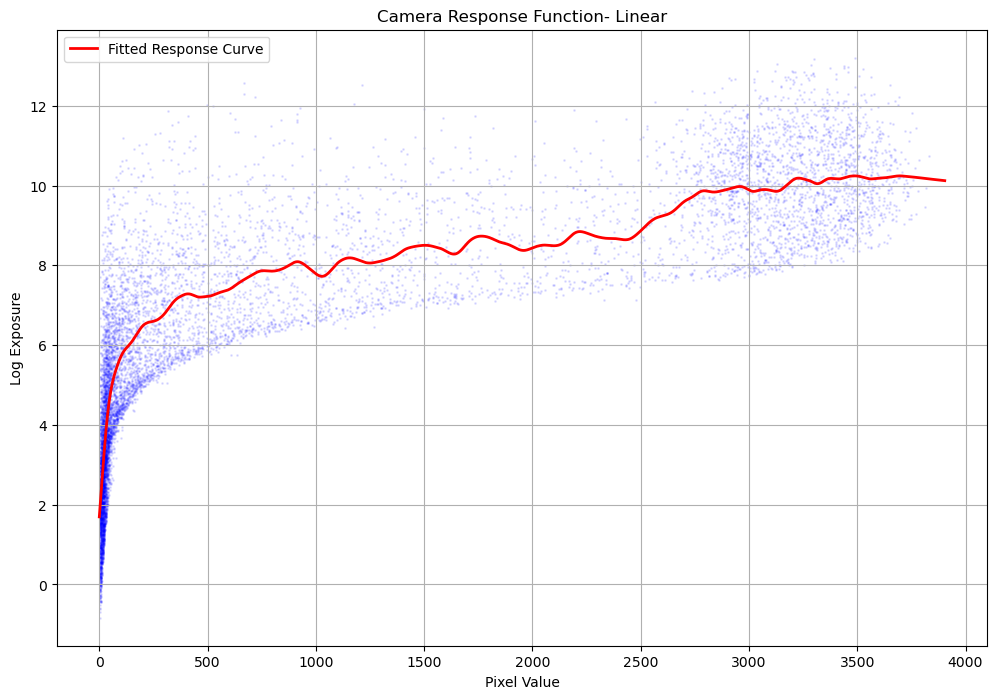

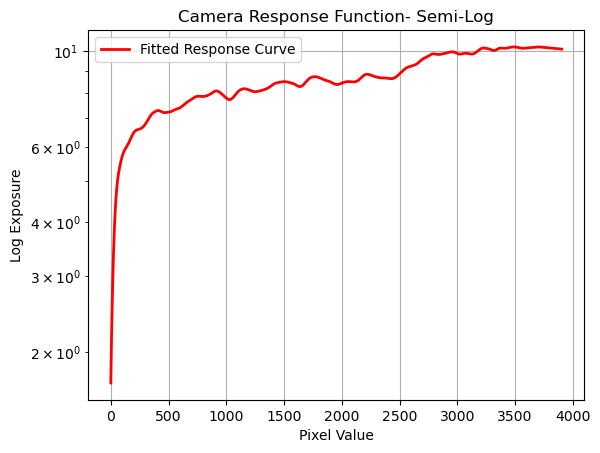

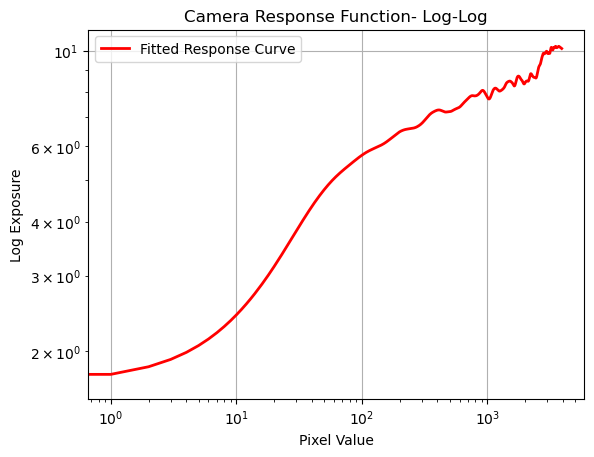

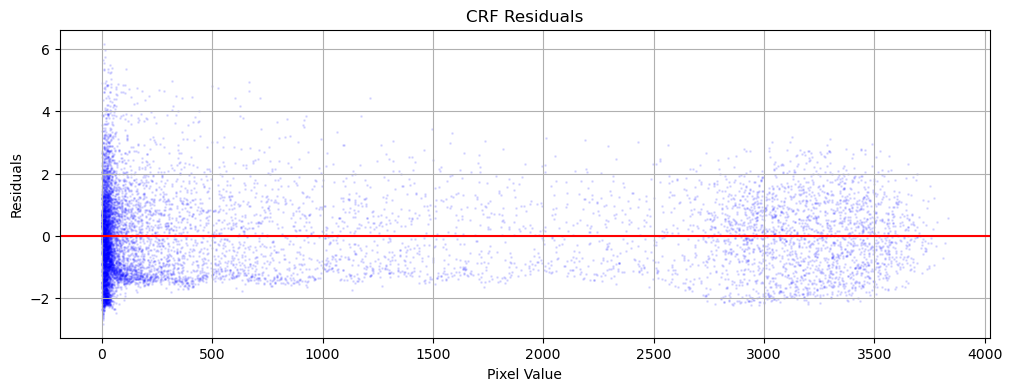

1. Radiance map (log space) min: 2.1059327125549316, max: 9.061097145080566


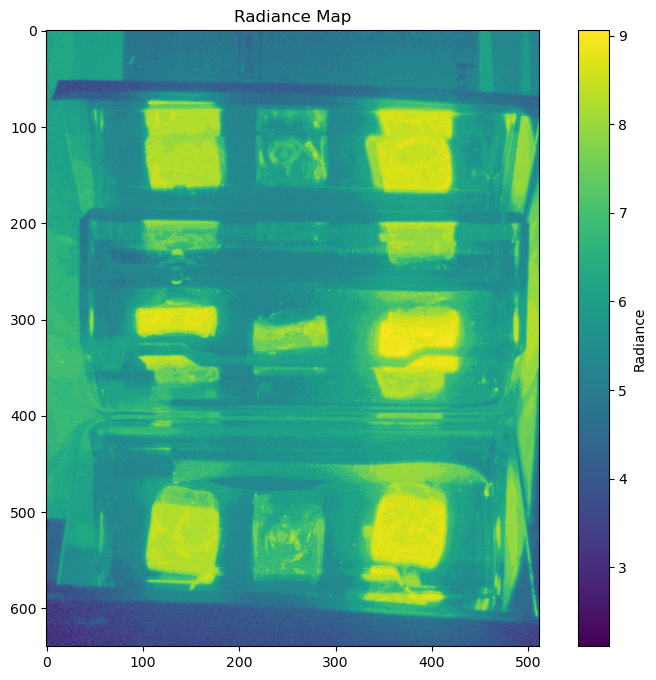

2. Radiance map (linear space) min: 8.214761734008789, max: 8613.595703125


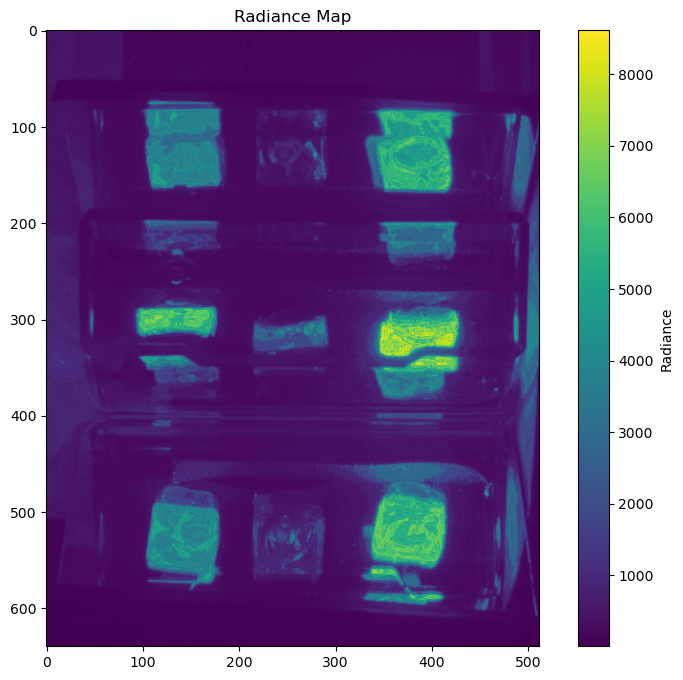

3. Normalized radiance map min: 0.0, max: 1.0


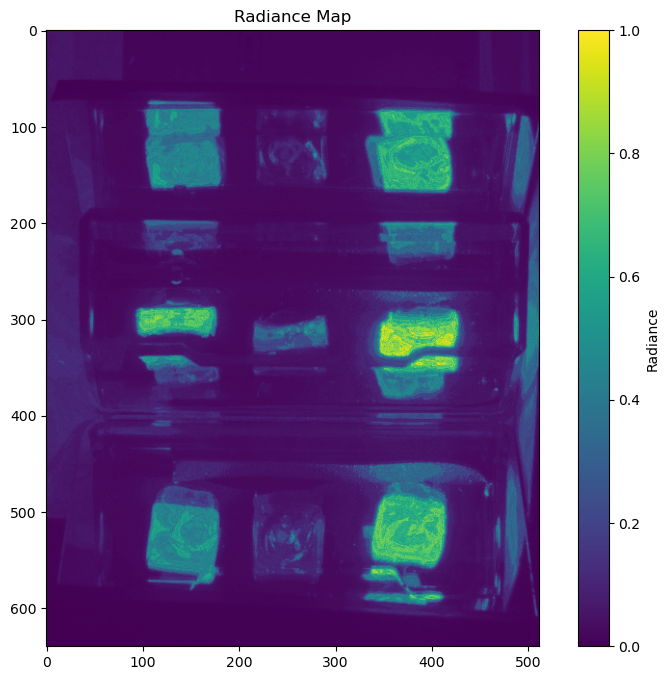

4. After tone mapping min: 0.0, max: 1.0


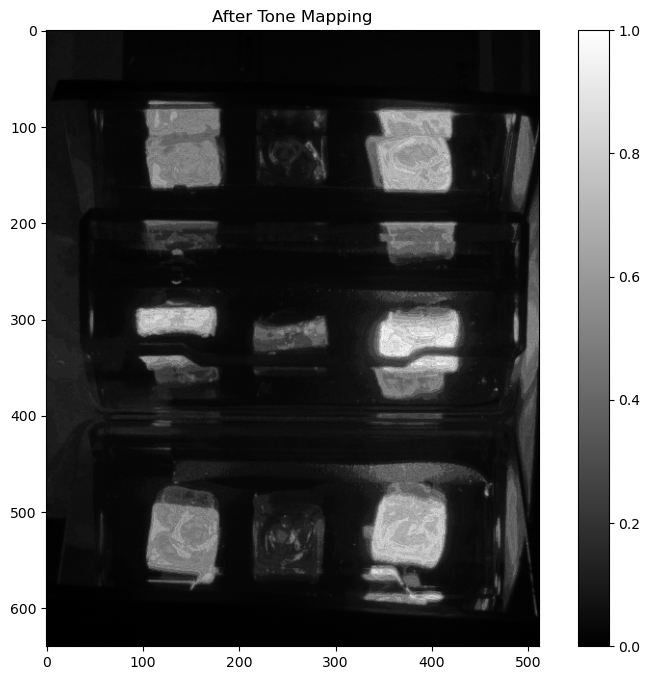

5. After intensity adjustment min: 0.0, max: 449.8216247558594
6. Final HDR image min: 0, max: 255


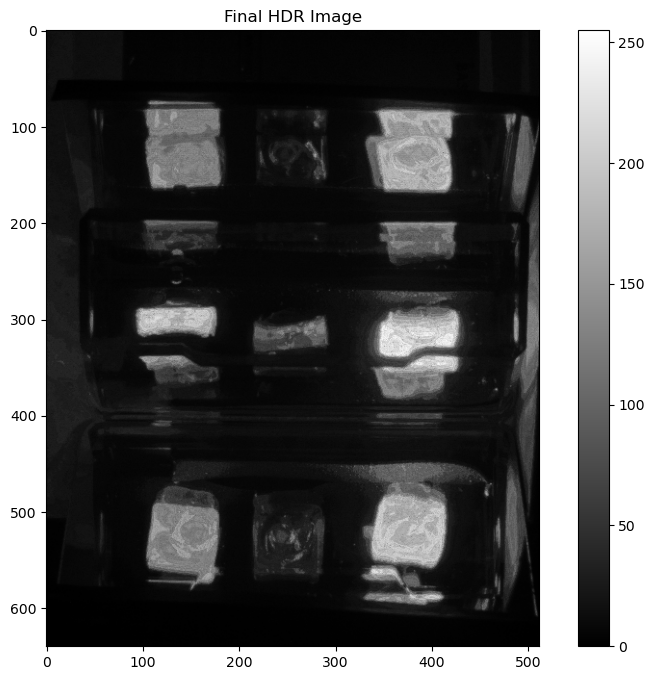

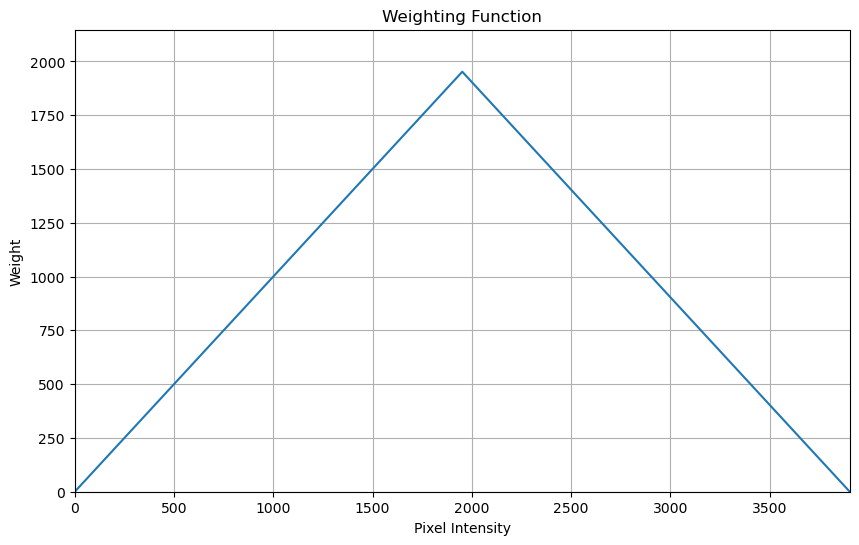

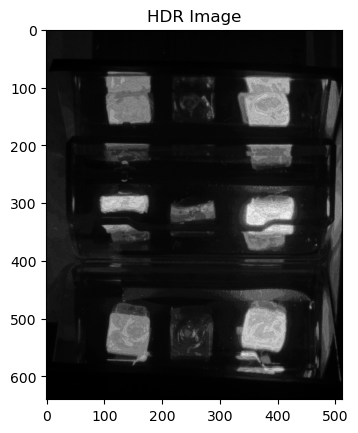

In [154]:
# Choose a specific image set for HDR processing
key = 'Water_immersed_670_BP1150'  # Or any other key from your data
images = data['denoised_images'][key]
log_exposure_times = np.log(data['exposure_times'])
exposure_times = (data['exposure_times'])

print(images)

# Compute HDR image and get response curve
hdr_image, response_curve = computeHDR(images, exposure_times)

# Plot the weighting function
z_min, z_max = np.min(images), np.max(images)
plot_weighting_function(linearWeight, z_min, z_max)


# Display the HDR image
plt.figure()
plt.imshow(hdr_image, cmap='gray')
plt.title("HDR Image")
plt.show()